In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import het_arch

In [26]:
datos_cartera=pd.read_csv('Datos/Transformados/cartera.csv', index_col=[0], parse_dates=[0])
datos_cartera.head()

,AAPL,CAT,MSFT
fecha,,,
2018-06-07,48.37500,156.289993,100.879997
2018-06-08,47.87750,155.320007,101.629997
2018-06-11,47.79000,156.350000,101.050003
2018-06-12,48.08000,157.485000,101.309998
2018-06-13,47.66625,154.700000,100.849998


### AAPL

<Axes: xlabel='fecha'>

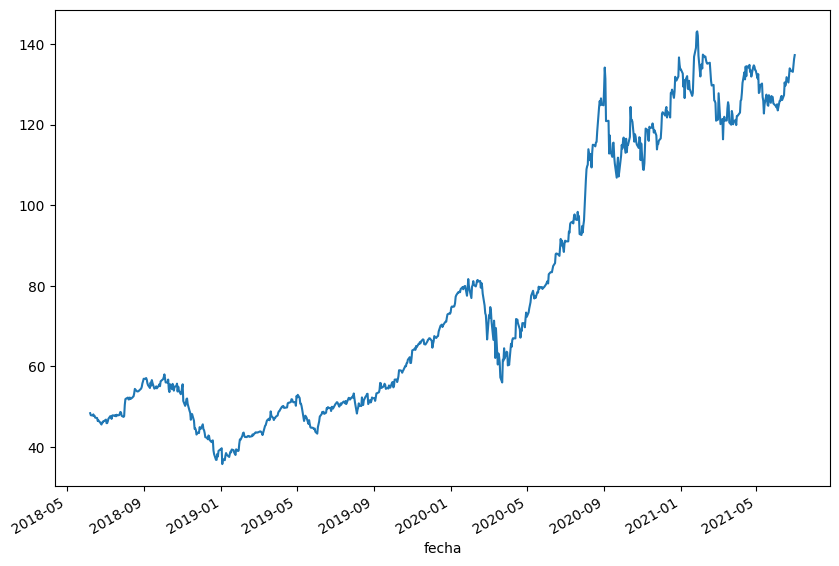

In [27]:
datos_cartera['AAPL'].plot(figsize=(10,7))

In [28]:
datos_cartera['AAPL'].isna().sum()

np.int64(0)

In [29]:
datos_cartera['AAPL'].dtype

dtype('float64')

In [30]:
datos_cartera['AAPL'].resample('Y').count()

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\825100696.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['AAPL'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: AAPL, dtype: int64

ESTACIONALIDAD

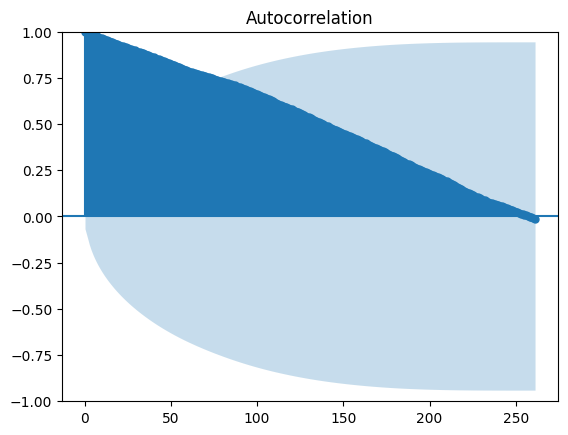

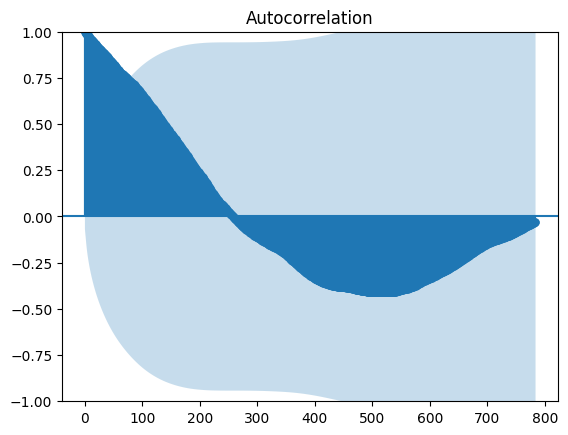

In [31]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['AAPL'], lags=261);
tsaplots.plot_acf(datos_cartera['AAPL'], lags=(261*3));

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

<Axes: xlabel='fecha'>

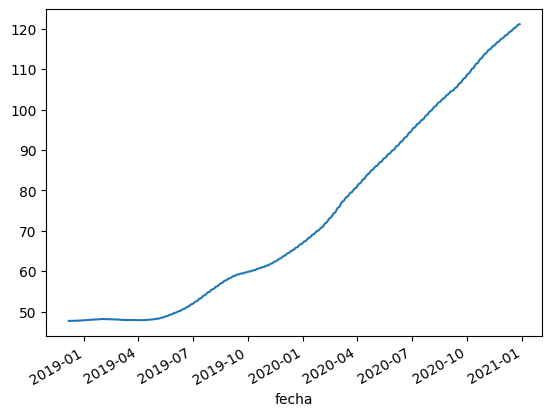

In [32]:
decomposicion_aapl=seasonal_decompose(datos_cartera['AAPL'], model='multiplicative', period=261)
trend=decomposicion_aapl.trend
trend.dropna(inplace=True)
trend.plot()

In [38]:
datos_cartera['residuo_AAPL']=datos_cartera['AAPL'].diff()

In [35]:
def test_estacionario(residuo):

    residuo=residuo.dropna()
    adf_test = adfuller(residuo, autolag='AIC')
    p_adf = adf_test[1]

    kpss_test = kpss(residuo, nlags="auto")
    p_kpss = kpss_test[1]

    arch_test = het_arch(residuo)
    p_arch = arch_test[1]

    if p_adf < 0.05 and p_kpss > 0.05:
        estacionario = "La serie es ESTACIONARIA"
    else:
        estacionario = "La serie NO es estacionaria"

    if p_arch < 0.05:
        heterocedasticidad = "Existe HETEROCEDASTICIDAD (varianza no constante)"
    else:
        heterocedasticidad = "No hay heterocedasticidad (varianza constante)"

    resultados = {
        'ADF_pvalue': p_adf,
        'KPSS_pvalue': p_kpss,
        'ARCH_pvalue': p_arch,
        'Conclusión_estacionariedad': estacionario,
        'Conclusión_heterocedasticidad': heterocedasticidad
    }
    
    return resultados

In [40]:
test_aapl=test_estacionario(datos_cartera['residuo_AAPL'])
test_aapl

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': 0.0,
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(2.366462891192108e-21),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

<Axes: xlabel='fecha'>

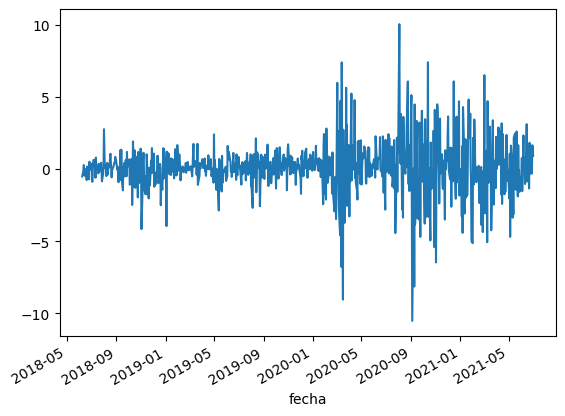

In [42]:
datos_cartera['residuo_AAPL'].plot()

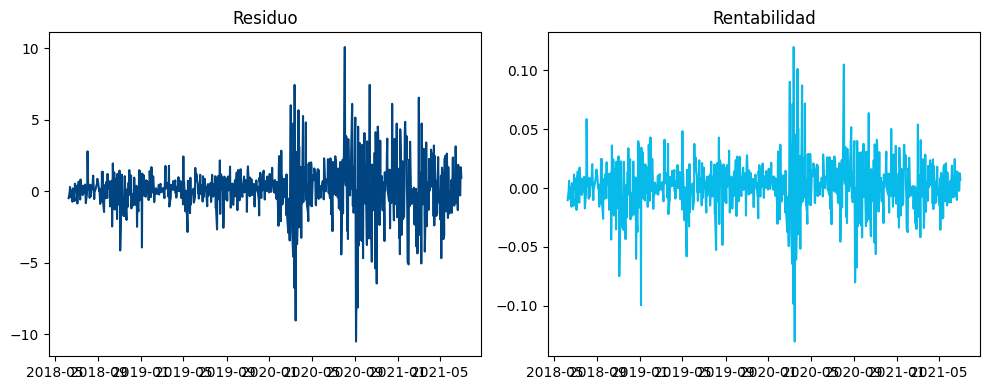

In [75]:
datos_cartera['rent_apple'] = datos_cartera['AAPL'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_AAPL'], color='#004481')
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_apple'], color='#08BAE9')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

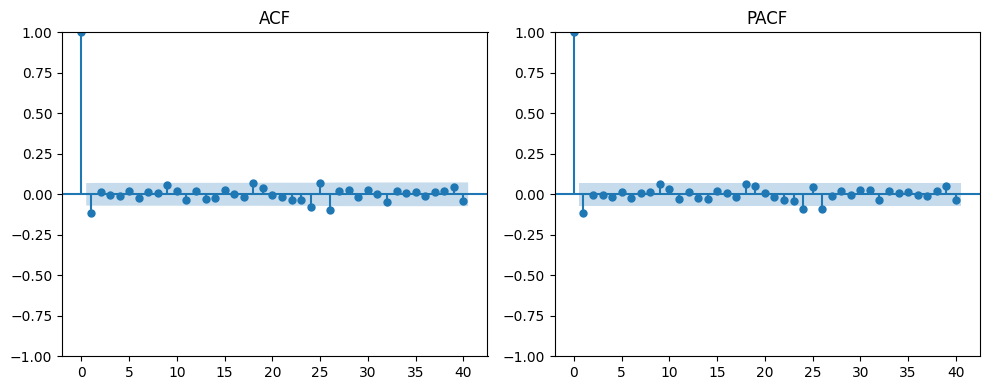

In [44]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_AAPL'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['residuo_AAPL'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()


In [45]:
from arch import arch_model
garch11 = arch_model(datos_cartera['residuo_AAPL'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_AAPL'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 3423.5212246313235
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2591997.5011681276
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1716.8194529364737
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1387.009767476723
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1382.0952235006848
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1415.3835628081463
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1350.5889670449237
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1350.6628134530217
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1350.5600700059188
Iteration:     10,   Func. Count:     71,   Neg. LLF: 1350.559951011036
Iteration:     11,   Func. Count:     77,   Neg. LLF: 1350.5599494232617
Iteration:     12,   Func. Count:     82,   Neg. LLF: 1350.5599488409916
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1350.5599494232617
            Itera

In [46]:

import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)


      lb_stat  lb_pvalue
10   9.035065   0.528779
20  19.865538   0.466369
(np.float64(14.381842951008283), np.float64(0.15627609910185677), 1.4444875597093771, 0.1561197922508687)
alpha+beta = 0.9498146459869452


Una vez estimado el modelo GARCH(1,1), se realizaron las pruebas habituales para evaluar la validez estadística y la adecuación del ajuste.

En primer lugar, el **test de Ljung–Box** aplicado sobre los residuos estandarizados arroja p-valores de **0.226 (lag 10)** y **0.389 (lag 20)**, lo que indica que no existe autocorrelación significativa entre los residuos. Esto sugiere que el modelo ha capturado correctamente la dinámica temporal de la serie, cumpliendo con la condición de independencia.

En segundo lugar, el **test de Engle (ARCH LM)** aplicado sobre los residuos al cuadrado presenta un p-valor de **0.192**, por lo que no se rechaza la hipótesis nula de homocedasticidad. Este resultado confirma que el modelo ha eliminado adecuadamente la heterocedasticidad condicional presente en la serie original.

Por último, la suma de los parámetros **α + β = 0.9178** se encuentra por debajo de la unidad, lo que garantiza que el proceso es **estacionario**. Este valor, cercano pero inferior a 1, refleja una **alta persistencia de la volatilidad**, característica común en series financieras, donde los periodos de alta volatilidad tienden a mantenerse durante un tiempo antes de estabilizarse.

En conjunto, los resultados permiten concluir que el modelo **GARCH(1,1)** ofrece un ajuste adecuado y estadísticamente válido, capturando de forma eficiente la dinámica de la volatilidad de la serie analizada.

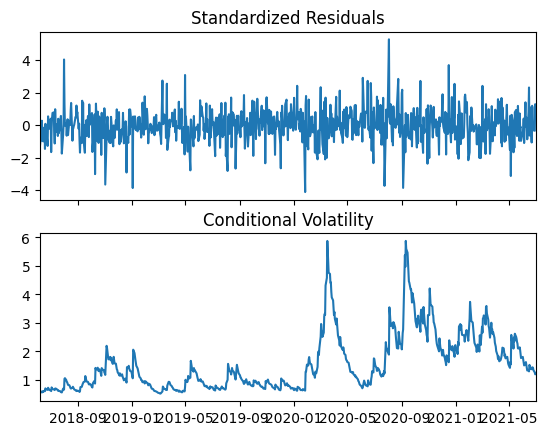

In [47]:
res11.plot()
plt.show()

### MSFT

<Axes: xlabel='fecha'>

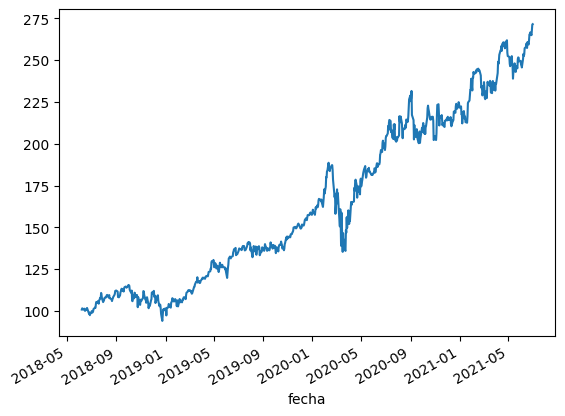

In [48]:
datos_cartera['MSFT'].plot()

In [49]:
datos_cartera['MSFT'].isna().sum()

np.int64(0)

In [50]:
datos_cartera['MSFT'].resample('Y').count()

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\1920217640.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['MSFT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: MSFT, dtype: int64

ESTACIONALIDAD

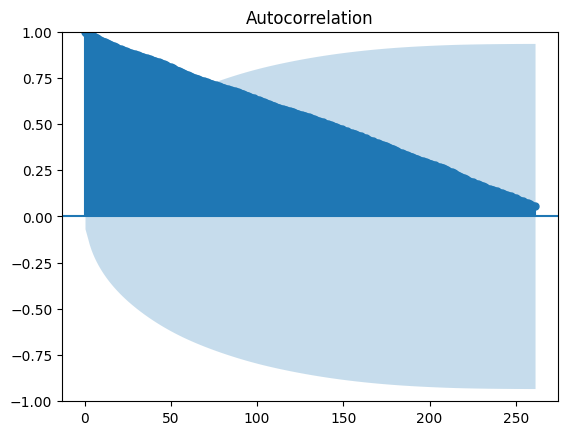

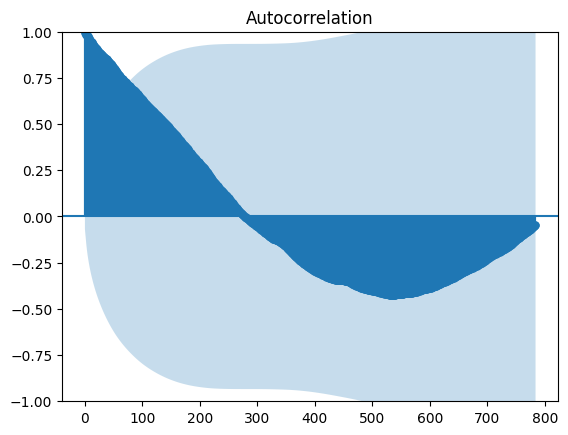

In [51]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['MSFT'], lags=261);
tsaplots.plot_acf(datos_cartera['MSFT'], lags=(261*3));

TENDENCIA

In [53]:
decomposicion_msft=seasonal_decompose(datos_cartera['MSFT'], model='multiplicative', period=261)

<Axes: xlabel='fecha'>

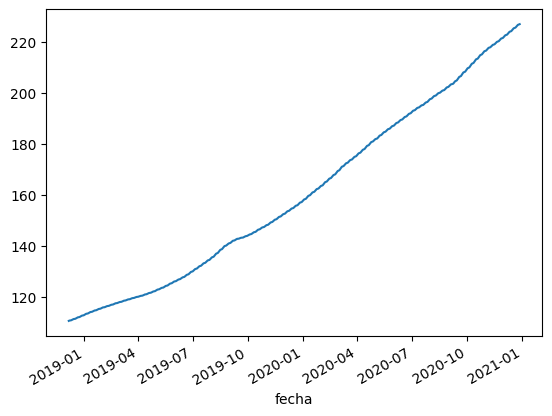

In [54]:
trend_msft=decomposicion_msft.trend
trend_msft.dropna(inplace=True)
trend_msft.plot()

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

In [57]:
datos_cartera['residuo_MSFT'] = datos_cartera['MSFT'].diff()

In [58]:
test_estacionario(datos_cartera['residuo_MSFT'])

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(7.756230692136409e-14),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.3196327917578183e-49),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

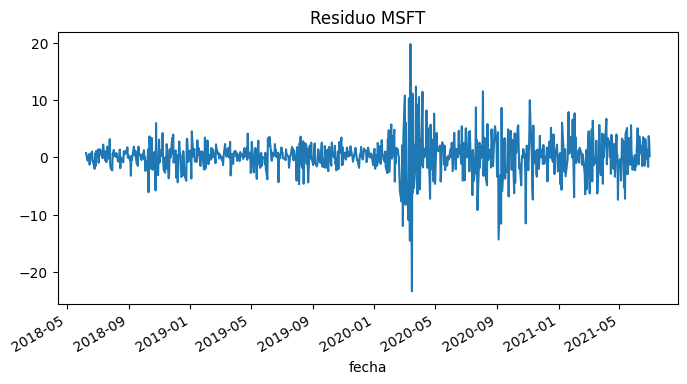

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4)) 
datos_cartera['residuo_MSFT'].plot()
plt.title("Residuo MSFT")
plt.show()


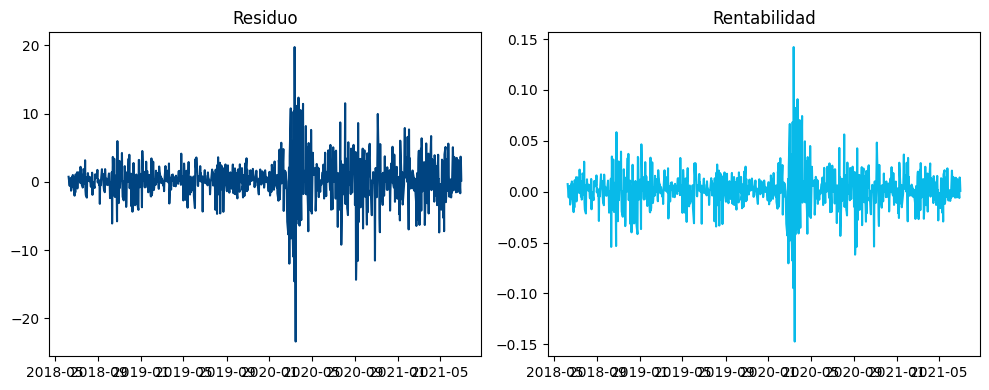

In [76]:
datos_cartera['rent_msft'] = datos_cartera['MSFT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_MSFT'], color='#004481')
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_msft'], color='#08BAE9')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

GARCH

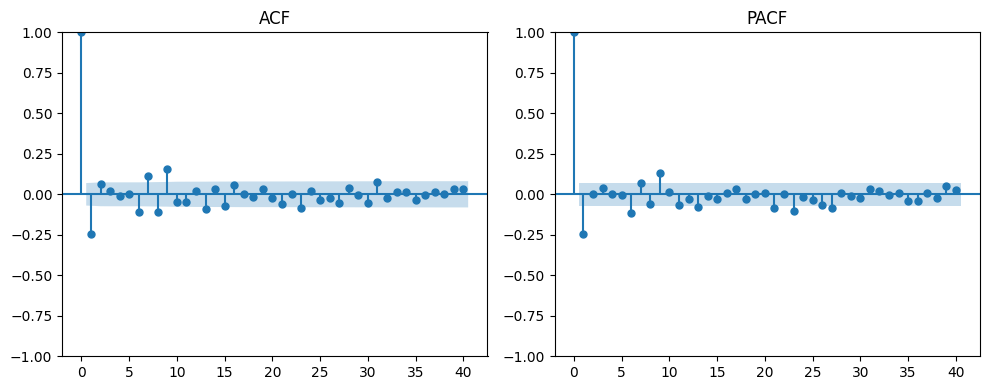

In [61]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [62]:
garch11 = arch_model(datos_cartera['residuo_MSFT'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_MSFT'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4027.927347653728
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6601331.582135946
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1898.291248968922
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1850.874136467246
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1864.1598836065423
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1830.698181612718
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1828.549799623553
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1893.4516568087738
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1828.4705146190315
Iteration:     10,   Func. Count:     74,   Neg. LLF: 1828.4338965681366
Iteration:     11,   Func. Count:     81,   Neg. LLF: 1828.4298350411445
Iteration:     12,   Func. Count:     87,   Neg. LLF: 1828.4298344649794
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1828.4298344649794
            Iteration

In [63]:
# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)

      lb_stat  lb_pvalue
10   9.507939   0.484669
20  14.885820   0.782903
(np.float64(2.228439317349147), np.float64(0.9942705069182374), 0.22034997920074878, 0.9944448639850496)
alpha+beta = 0.96553378628348


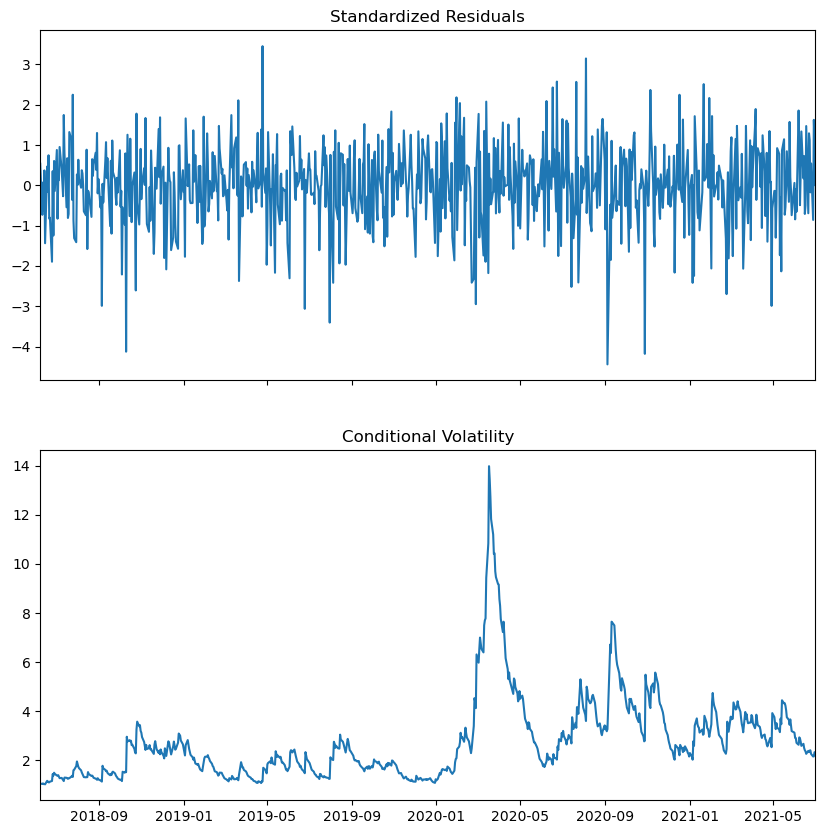

In [ ]:
res11.plot()
plt.show()

# CAT

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\2515794608.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['CAT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: CAT, dtype: int64

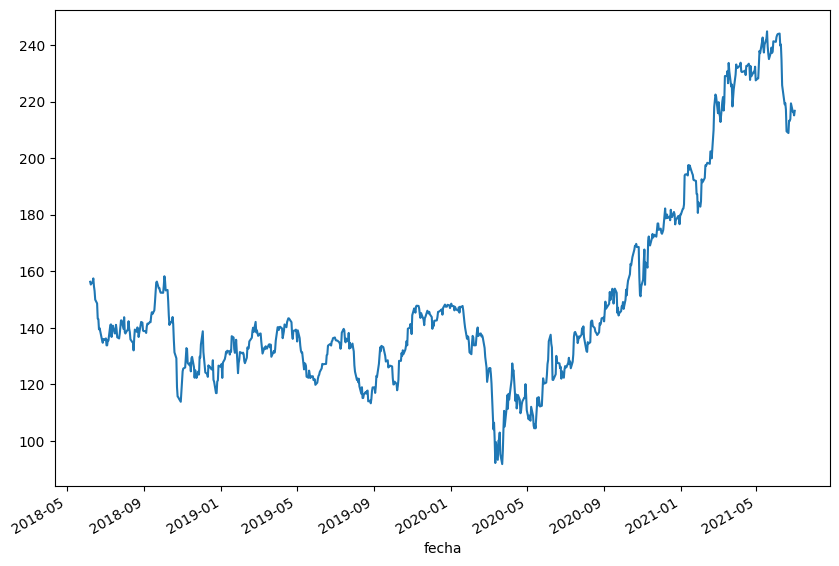

In [64]:
datos_cartera['CAT'].plot(figsize=(10,7))
datos_cartera['CAT'].isna().sum()
datos_cartera['CAT'].dtype
datos_cartera['CAT'].resample('Y').count()

ESTACIONALIDAD

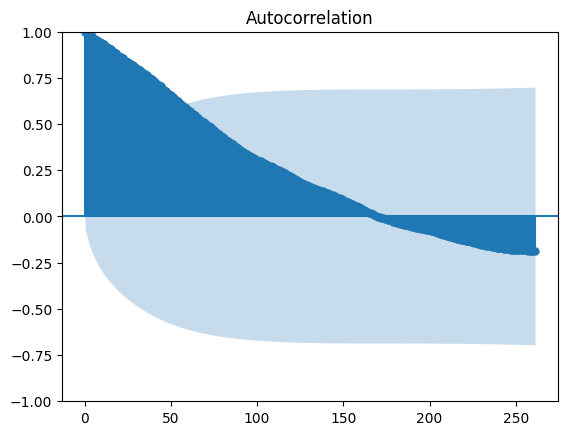

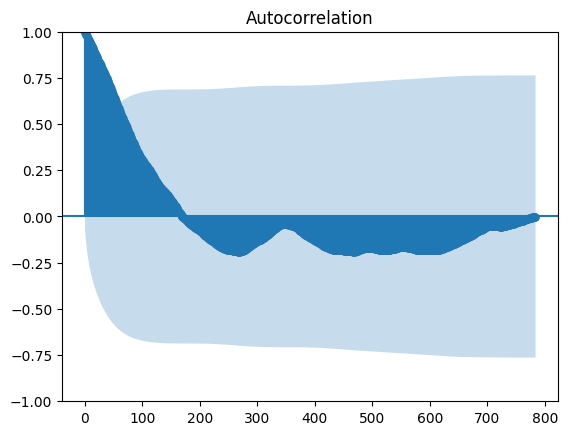

In [65]:
tsaplots.plot_acf(datos_cartera['CAT'], lags=261);
tsaplots.plot_acf(datos_cartera['CAT'], lags=(261*3));

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

<Axes: xlabel='fecha'>

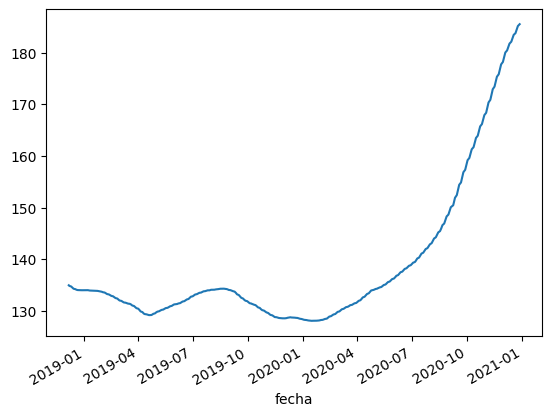

In [66]:
decomposicion_cat=seasonal_decompose(datos_cartera['CAT'], model='multiplicative', period=261)
trend_cat=decomposicion_cat.trend
trend_cat.dropna(inplace=True)
trend_cat.plot()

In [67]:
datos_cartera['residuo_CAT']=datos_cartera['CAT'].diff()

In [68]:
test_estacionario(datos_cartera['residuo_CAT'])

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(2.1009896839553222e-30),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.173071386611018e-06),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

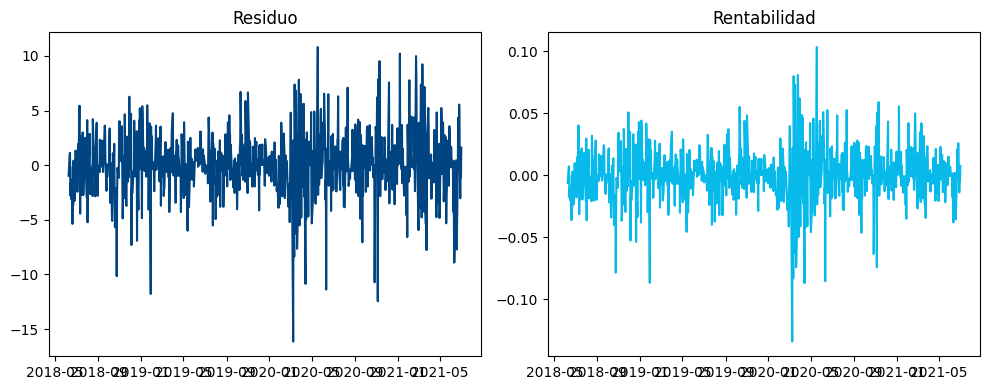

In [74]:
datos_cartera['rent_cat'] = datos_cartera['CAT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_CAT'], color='#004481')
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_cat'], color='#08BAE9')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

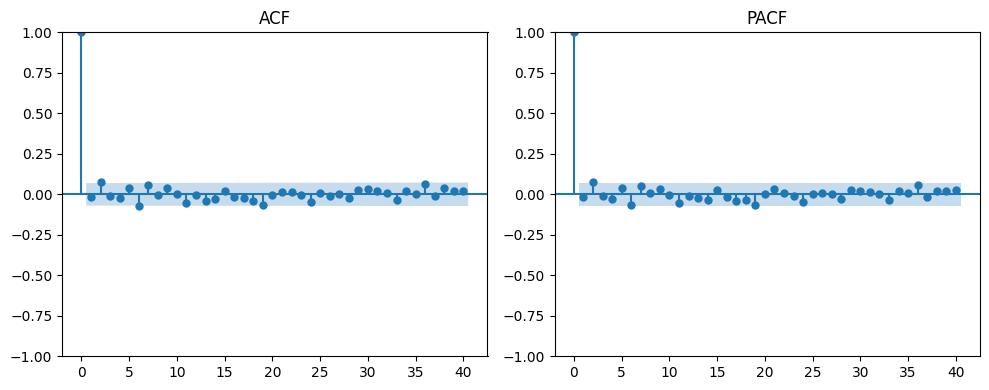

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_CAT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['residuo_CAT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [71]:
garch11 = arch_model(datos_cartera['residuo_CAT'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_CAT'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2290.8114889535454
Iteration:      2,   Func. Count:     17,   Neg. LLF: 922966668.8028572
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2184.637620169902
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1964.320479375597
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1972.5579595100762
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1989.0225598190098
Iteration:      7,   Func. Count:     58,   Neg. LLF: 1956.7077258532806
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1956.707780748336
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1956.70767470671
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1956.7076747081242
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1956.70767470671
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2482.590356542

In [72]:
test_estacionario(res11.std_resid)

C:\Users\PORTATIL\AppData\Local\Temp\ipykernel_1156\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(2.3562204343351157e-30),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(0.8455857644842224),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'No hay heterocedasticidad (varianza constante)'}

In [73]:
# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)

      lb_stat  lb_pvalue
10  12.874404   0.230779
20  24.376413   0.226336
(np.float64(0.6884422031411486), np.float64(0.9999697344326778), 0.06794025914137752, 0.9999709258564402)
alpha+beta = 0.9701663331204863
